<a href="https://colab.research.google.com/github/ravellys/PID-MP/blob/master/Segmentacao_utilizando_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import imageio

%matplotlib inline

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


# Funções básicas

In [3]:
def plot_comp_slice(slice, im, im_bin):
  fig, axes = plt.subplots(ncols=3, figsize=(16, 5))
  ax = axes.ravel()
  ax[0] = plt.subplot(1, 3, 1)
  ax[1] = plt.subplot(1, 3, 2)
  ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

  ax[0].imshow(im[:,:, slice], cmap=plt.cm.gray)
  ax[0].set_title('Original')
  ax[0].axis('off')

  ax[1].hist(im.ravel(), range=(im.min(),im.max()), bins=2**8)
  ax[1].set_title('Histogram')

  ax[2].imshow(im_bin[:, :, slice], cmap=plt.cm.gray)
  ax[2].set_title('Segmentada')
  ax[2].axis('off')

  plt.show()

In [4]:
#plota imagem
def plot_im(im, im_bin, pos = 4):   
  fig, axes = plt.subplots(ncols=3, figsize=(16, 5))
  ax = axes.ravel()
  ax[0] = plt.subplot(1, 3, 1)
  ax[1] = plt.subplot(1, 3, 2)
  ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

  ax[0].imshow(im[:,:, pos], cmap=plt.cm.gray)  
  ax[0].set_title('Original')
  ax[0].axis('off')

  ax[1].hist(im.ravel(), bins=2**8)
  ax[1].set_title('Histogram')

  plt.show()

In [5]:
def import_file(path):
  list_files = os.listdir(path) # lista de arquivos dentro da pasta das amostras
  list_files = np.sort(np.array(list_files)) # organizar os arquivos
  im = [] # inicialização do vetor de armazenamento

  for file_ in tqdm(list_files) :
    if file_[-3:] =='tif':
      fetch_file = os.path.join(path, file_)  
      image = np.array(imageio.imread(fetch_file)) # importa imagem e converte em numpy
 
      im.append(image.T) # Adiciona matriz numpy ao vetor de armazenameto

  im = np.array(im)
  return im 

In [6]:
#altera range dos tons de cinza
def im_alt_range(im, n_min=0, n_max=255):
  min = im.min()
  max = im.max()
  im_ = n_min +(im - min)*(n_max - n_min)/(max - min)
  return im_.astype(int)

In [7]:
def im_recort(im,x,y,z):
  x_size,y_size,z_size = im.shape
  s_x,s_y,s_z = np.array([(x_size-x)/2,(y_size-y)/2,(z_size-z)/2]).astype(int)
  e_x,e_y,e_z = np.array([x_size-(x_size-x)/2,y_size-(y_size-y)/2,z_size-(z_size-z)/2]).astype(int)

  return im[s_x:e_x,s_y:e_y,s_z:e_z] # separa uma região de 400x400x400

In [8]:
# Plota imagem e secção horizontal
def im_sec_plot(img, pos=100, bits=8):
  leny,lenx = img.shape
  line = img[pos,:]

  x = np.linspace(0,len(line),len(line))
  fig,ax = plt.subplots(ncols=2, figsize = (15,7))
  ax = ax.ravel()

  ax[0].plot(x,line)
  ax[0].grid()

  ax[1].imshow(img,"gray")
  ax[1].hlines(pos, 0, lenx,color = 'red')
  ax[1].set_xlim(0, lenx)

  plt.show()  

# Importando dados

In [9]:
# importar dataset 
path = 'drive/My Drive/Artigo Segmentação/Imagens/VN19/VN19_14/VN19_14_40gHu' #pasta da amostra
im = import_file(path)
print(im.shape)

100%|██████████| 905/905 [07:19<00:00,  2.06it/s]


(905, 1004, 1006)


In [10]:
im_rc = im_recort(im, 400, 400, 400) # recortar a imagem

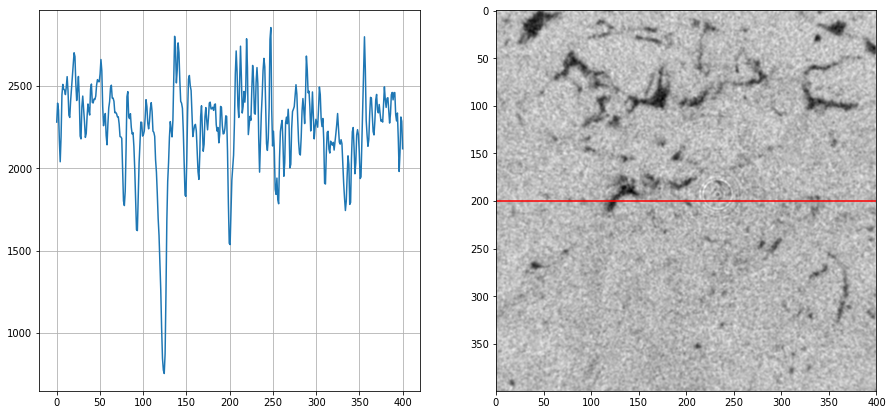

In [11]:
seccao = 10
im_sec_plot(im_rc[seccao], pos=200, bits=16)

In [12]:
def init_ravel(X, n_clusters):
  n_features=1
  init = []
  a = 0
  for i in range(n_clusters):
    a += 1/(n_clusters+1)
    p = np.percentile(X, a)
    init.append([p]*n_features)

  init = np.array(init) # (n_clusters, n_features) 
  return init

In [13]:
from sklearn import cluster

def kmean(im, n_clusters):
  X = im.reshape(-1,1)
  init = init_ravel(X, n_clusters)  
  k_means = cluster.KMeans(n_clusters=n_clusters, tol=.001, init=init)
  labels = k_means.fit_predict(X)

  return labels.reshape(im.shape) 

def mb_kmean(im, n_clusters):
  X = im.reshape(-1,1)
  init = init_ravel(X, n_clusters)  
  k_means = cluster.MiniBatchKMeans(n_clusters=n_clusters, tol=.001, init=init)
  labels = k_means.fit_predict(X)

  return labels.reshape(im.shape)  

def birch(im, n_clusters):
  X = im.reshape(-1,1) 
  birch = cluster.Birch(threshold=0.1, n_clusters=n_clusters)
  labels = birch.fit_predict(X)

  return labels.reshape(im.shape)    

def dbscan(im, n_clusters):
  X = im.reshape(-1,1) 
  dbscan = cluster.DBSCAN(eps=.01, min_samples=10)
  labels = dbscan.fit_predict(X)

  return labels.reshape(im.shape) 

def mean_shift(im, n_clusters):
  X = im.reshape(-1,1)
  bandwidth = cluster.estimate_bandwidth(X, quantile=0.2, n_samples=300)

  ms = cluster.MeanShift(bandwidth=bandwidth, max_iter=1)
  labels = ms.fit_predict(X)

  return labels.reshape(im.shape)

def affinity_propagation(im, n_clusters):
  X = im.reshape(-1,1)
  ap = cluster.AffinityPropagation(copy=False)
  labels = ap.fit_predict(X)

  return labels.reshape(im.shape)  


In [32]:
from skimage.filters import threshold_multiotsu
def multi_otsu(im: np.array, n_clusters: int = 3):
  multi_thresh = threshold_multiotsu(im.ravel(), classes=n_clusters) # Determina limiar de poros e solidos
  print(type(im))

  im_otsu = np.copy(im)*0
  for i, thresh in enumerate(multi_thresh):
    print(thresh)
    im_otsu[im >= thresh] = i+1

  return np.array(im_otsu).astype(int) 

In [30]:
from skimage.filters import threshold_otsu
def otsu(im):
  thresh = threshold_otsu(im.ravel()) # Determina limiar de poros e solidos
  im_otsu = im > thresh

  return np.array(im_otsu).astype(int) 

In [31]:
im_kmean = kmean(im_rc, n_clusters=3)

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1008: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return self.fit(X, sample_weight=sample_weight).labels_
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1008: RuntimeWarning: Explicit initial center position passed: performing only one init in MiniBatchKMeans instead of n_init=3
  return self.fit(X, sample_weight=sample_weight).labels_


TypeError: ignored

In [ ]:
im_mb_kmean = mb_kmean(im_rc, n_clusters=3)

In [33]:
im_otsu = multi_otsu(im_rc, n_clusters=3)

<class 'numpy.ndarray'>
1422
2155


In [54]:
def porosity(im):
  arr_unique = np.unique(im)
  meio = arr_unique[len(arr_unique)//2]
  im_poros = im <= meio
  return round(im_poros.sum()/np.prod(im_poros.shape), 5)

print("porosidade:\n")  
print('otsu:', porosity(im_otsu) )
print('kmean:', porosity(im_kmean) )
print('mini batch kmean:', porosity(im_mb_kmean) )

porosidade:

otsu: 0.31315
kmean: 0.28396
mini batch kmean: 0.27498


In [38]:
(im_otsu == 0).sum()

5378960

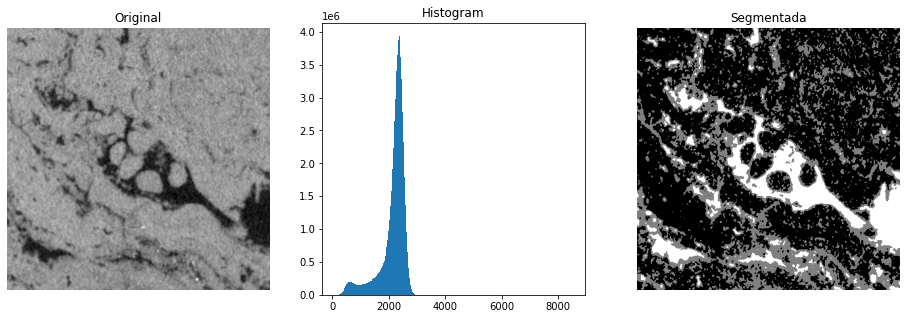

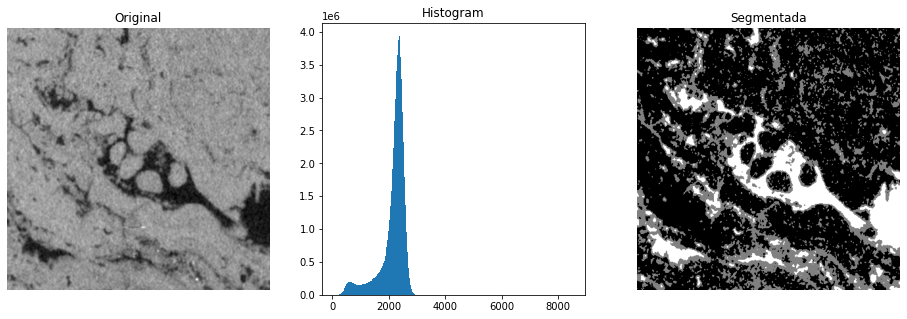

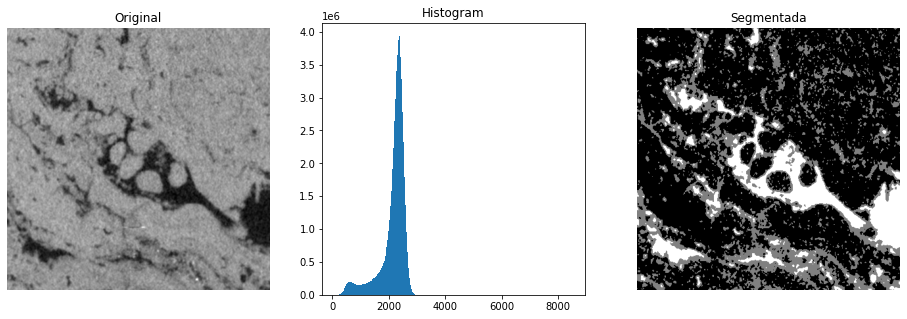

In [55]:
plot_comp_slice(200, im_rc, 1-im_otsu)
plot_comp_slice(200, im_rc, 1-im_kmean)
plot_comp_slice(200, im_rc, 1-im_mb_kmean)